# Linear regression. Part 1

---

## Linear and Logistic Regressions: prediction and metric


Applied Mathematical Modeling in Banking

---

# 1. Dataset overview

У даному навчальному матеріалі використано класичний приклад даних з інформацією про престижність професій у Канаді 1971 року. Джерело: carData::Prestige.

In [1]:
#install.packages("carData")
library(carData)

In [2]:
data <- carData::Prestige
head(data)

,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
gov.administrators,13.11,12351,11.16,68.8,1113,prof
general.managers,12.26,25879,4.02,69.1,1130,prof
accountants,12.77,9271,15.70,63.4,1171,prof
purchasing.officers,11.42,8865,9.11,56.8,1175,prof
chemists,14.62,8403,11.68,73.5,2111,prof
physicists,15.64,11030,5.13,77.6,2113,prof


Переглянемо структуру даних:

In [3]:
str(data)

'data.frame':	102 obs. of  6 variables:
 $ education: num  13.1 12.3 12.8 11.4 14.6 ...
 $ income   : int  12351 25879 9271 8865 8403 11030 8258 14163 11377 11023 ...
 $ women    : num  11.16 4.02 15.7 9.11 11.68 ...
 $ prestige : num  68.8 69.1 63.4 56.8 73.5 77.6 72.6 78.1 73.1 68.8 ...
 $ census   : int  1113 1130 1171 1175 2111 2113 2133 2141 2143 2153 ...
 $ type     : Factor w/ 3 levels "bc","prof","wc": 2 2 2 2 2 2 2 2 2 2 ...


Значення показників вибірки:

- [x] prestige – престиж професії за Pineo-Porter score, на основі дослідження середини 1960-х. **It is target!!!**
- [x] education - середня кількість років освіти.
- [x] income – середній дохід респондентів, дол.
- [x] women – частка жінок у галузі
- [x] census – канадський код професії.
- [x] type – тип професії: bc, Blue Collar; prof, Professional, Managerial, and Technical; wc, White Collar.

Оглянемо описову статистику факторів:

In [4]:
summary(data)

   education          income          women           prestige    
 Min.   : 6.380   Min.   :  611   Min.   : 0.000   Min.   :14.80  
 1st Qu.: 8.445   1st Qu.: 4106   1st Qu.: 3.592   1st Qu.:35.23  
 Median :10.540   Median : 5930   Median :13.600   Median :43.60  
 Mean   :10.738   Mean   : 6798   Mean   :28.979   Mean   :46.83  
 3rd Qu.:12.648   3rd Qu.: 8187   3rd Qu.:52.203   3rd Qu.:59.27  
 Max.   :15.970   Max.   :25879   Max.   :97.510   Max.   :87.20  
     census       type   
 Min.   :1113   bc  :44  
 1st Qu.:3120   prof:31  
 Median :5135   wc  :23  
 Mean   :5402   NA's: 4  
 3rd Qu.:8312            
 Max.   :9517            

# 2. Train/Test split

Розділимо загальну вибірку на 2 частини: * тренувальна, 70% вибірки, для побудови регресії; * тестова, 30% вибірки, для перевірки точності моделі.

In [5]:
set.seed(10) #довільне число як точка "відправки" для генератора випадкових чисел

# Згенеруємо набір чисел від 1 до кількості спостережень у вибірці і відберемо випадквоим чином 70% із них
train_index <- sample(1:nrow(data), size = 0.7*nrow(data))

#Виведемо індекси (номери рядків) обраних для тренування даних
print(train_index)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

 [1]   9  74  76  55  72  54  39  83  88  15  93  42  71 101  34  24  13   8   7
[20]  27  82  29  81  50  26  33  84  78  79  30  68  51  97  59  32  11  77  91
[39]  28  95  65  14  86  66  41  25  85  16  53  75  57  17  48  23  92  46  87
[58]  94   4  35  61  69  43  10  96  99  89  31  38  52  18


In [6]:
#Запишемо по номерах відібраних рядків тренувальний набір даних
train_data <- data[train_index,]
head(train_data)

#Всі інші значення, що не увійшли в тренувальну вибірку запишемо у тестову
test_data <- data[-train_index,]
head(test_data)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
civil.engineers,14.52,11377,1.03,73.1,2143,prof
textile.weavers,6.69,4443,31.36,33.3,8267,bc
tool.die.makers,10.09,8043,1.50,42.5,8311,bc
insurance.agents,11.60,8131,13.09,47.3,5171,wc
slaughterers.2,7.64,5134,17.26,34.8,8215,bc
service.station.attendant,9.93,2370,3.69,23.3,5145,bc


,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
gov.administrators,13.11,12351,11.16,68.8,1113,prof
general.managers,12.26,25879,4.02,69.1,1130,prof
accountants,12.77,9271,15.70,63.4,1171,prof
chemists,14.62,8403,11.68,73.5,2111,prof
physicists,15.64,11030,5.13,77.6,2113,prof
draughtsmen,12.30,7059,7.83,60.0,2163,prof


# 3. Short EDA (Exploratory data analysis)

## 3.1. Correlation

Переглянемо наявність зв’язків між параметрами за допоомгою матриці попарних кореляцій. Дані на перетині рядків вказують на рівень кореляції між вибраними показниками.

Виключимо змінну type, оскільки вона не має числового представлення:

In [7]:
cor(train_data[,-6])

,education,income,women,prestige,census
education,1.0000000,0.6243784,0.1507510,0.8448752,-0.8212488
income,0.6243784,1.0000000,-0.3910854,0.7425534,-0.3037354
women,0.1507510,-0.3910854,1.0000000,0.0227754,-0.3431387
prestige,0.8448752,0.7425534,0.0227754,1.0000000,-0.5968525
census,-0.8212488,-0.3037354,-0.3431387,-0.5968525,1.0000000


Lets view correlation matrix with `corrplot()` function:

corrplot 0.88 loaded



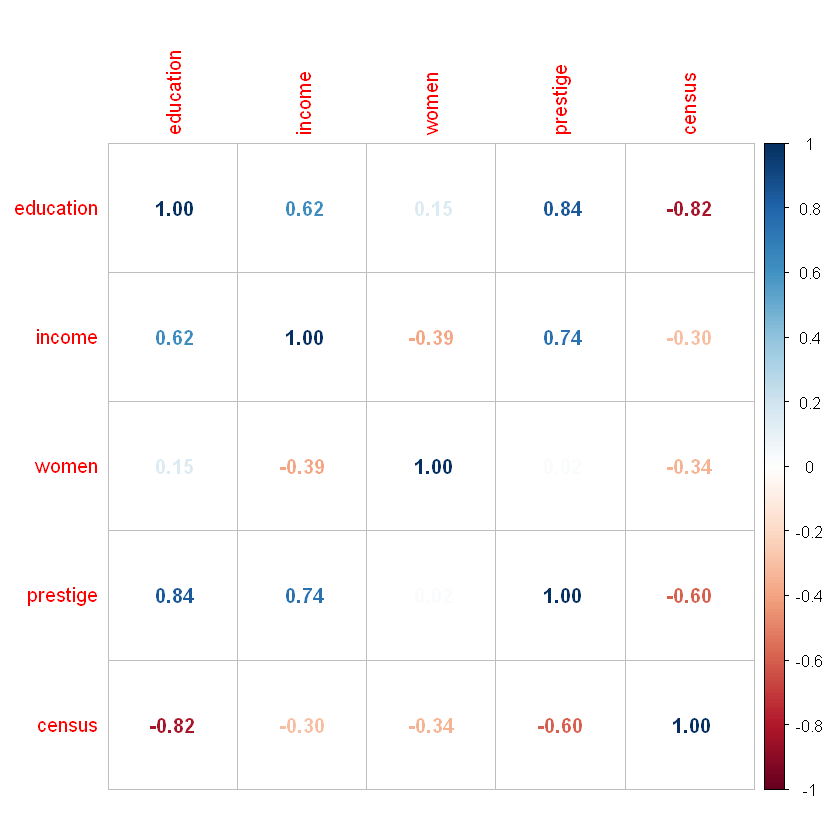

In [8]:
#install.packages("corrplot")
library(corrplot)
corrplot(cor(train_data[,-6]) , method = "number") 

You can see hight correlation between `education ~ prestige`, `education ~ census`, `prestige ~ income`.

## 3.2. Visual analysis

Lets check data distribution of some variables 

Target/Output variable `prestige`:

Warning message:
"package 'ggplot2' was built under R version 4.1.0"


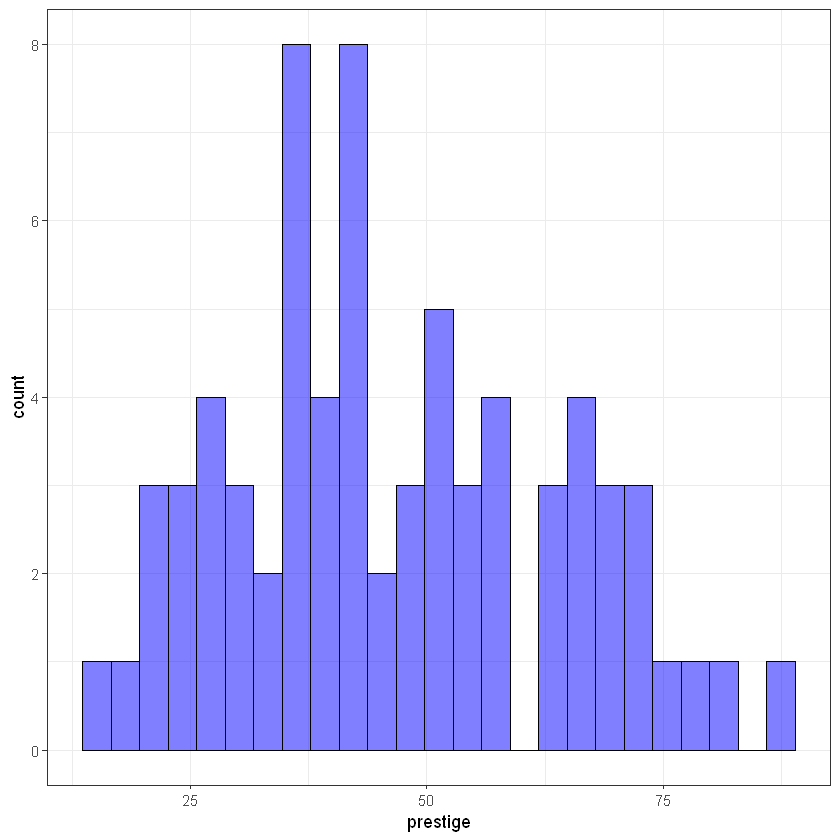

In [9]:
library(ggplot2)

ggplot(train_data, aes(prestige)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `income`:

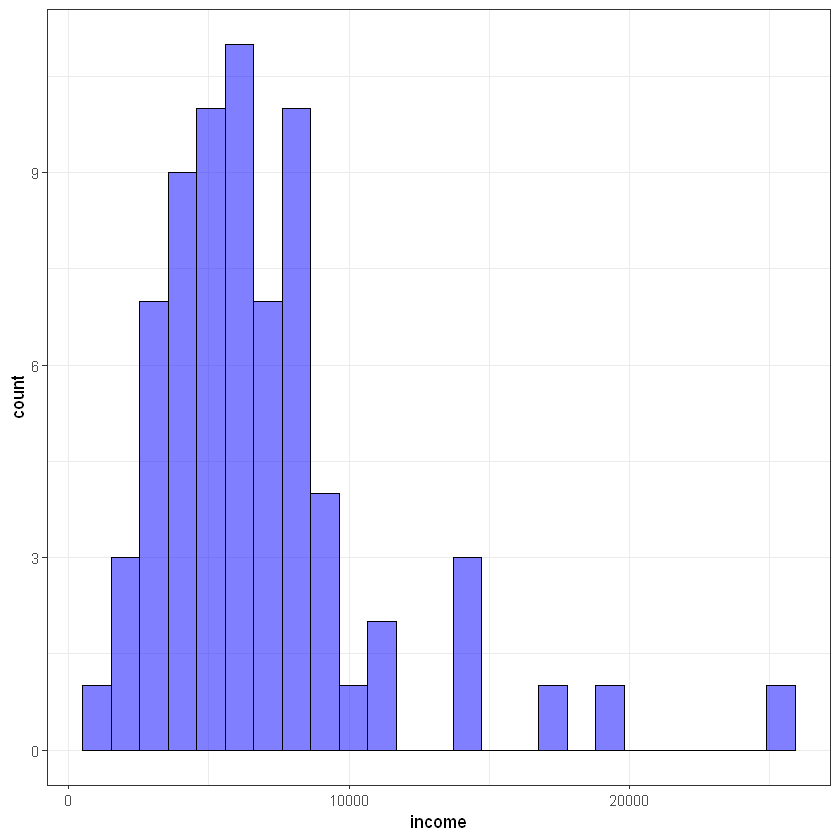

In [10]:
ggplot(train_data, aes(income)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `women`:

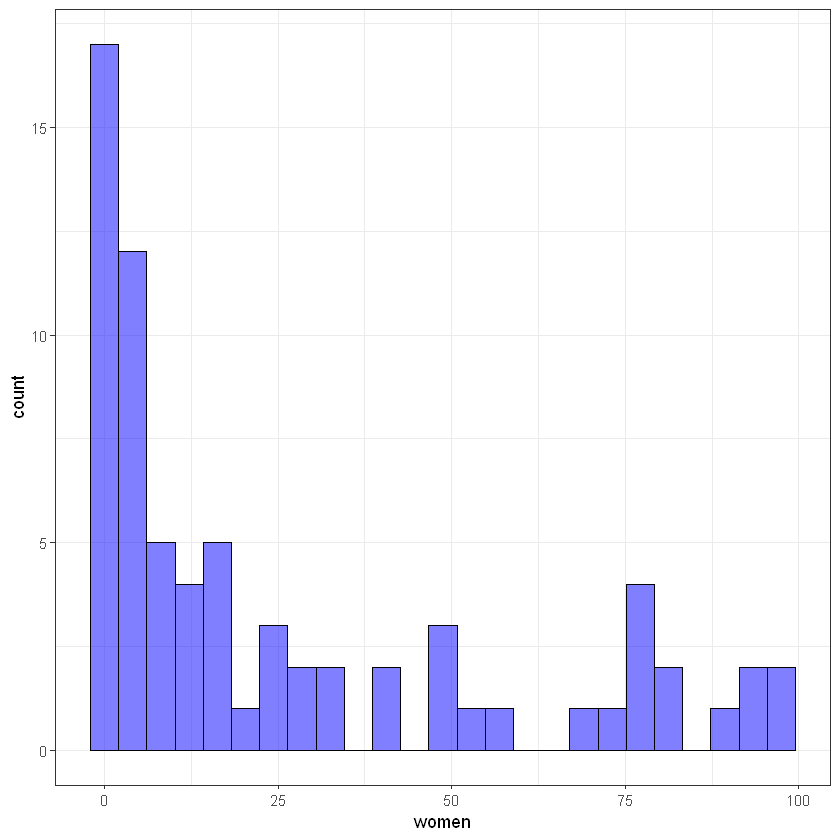

In [11]:
ggplot(train_data, aes(women)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

---

# 4. Model building

Функція `lm()` використовується для побудови лінійної регресії.

Syntax: `lm(formula, data = train_data)`

`formula` дозволяє вказати на залежність між вхідними та вихідним параметром. У даному випадку `prestige` - залежна змінна (`Y`), а усі, що після знаку `~` - незалежні (`X`).


In [12]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

Для детальнішого опису параметрів побудованої моделі варто скористатися функцією `summary()`:

In [13]:
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.2951  -4.7988   0.1218   5.1932  17.1181 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.9237106  3.9637472  -1.494     0.14    
income       0.0014932  0.0003017   4.949 5.18e-06 ***
education    3.9135175  0.4460247   8.774 8.64e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.035 on 68 degrees of freedom
Multiple R-squared:  0.7896,	Adjusted R-squared:  0.7834 
F-statistic: 127.6 on 2 and 68 DF,  p-value: < 2.2e-16


---

## Demo task: generating final formula for regression

Спробуємо створити рядковий вигляд для побудованої регресії (шляхом звичайного “склеювання” рядків). Це завдання для закріплення знань з алгоритмічного програмування в R.

In [14]:
typeof(lm_mod) # out model has list structure, so, we can explore it by index or names

[1] "list"

In [15]:
# returns all information about used variables
lm_mod$terms

prestige ~ income + education
attr(,"variables")
list(prestige, income, education)
attr(,"factors")
          income education
prestige       0         0
income         1         0
education      0         1
attr(,"term.labels")
[1] "income"    "education"
attr(,"order")
[1] 1 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(prestige, income, education)
attr(,"dataClasses")
 prestige    income education 
"numeric" "numeric" "numeric" 

In [16]:
lm_mod$terms[[2]] # target variable name

prestige

In [17]:
lm_mod$coefficients # coefficients of the model

(Intercept)       income    education 
-5.923710650  0.001493228  3.913517546

Спочатку додамо назву залежної змінної:

In [18]:
str_formula <- paste(lm_mod$terms[[2]], " = ", sep="")
str_formula

[1] "prestige = "

Додамо перший коефіцієнт $а_0$, який записаний у моделі як `(Intercept)`. Функція `paste()` дозволяє об’єднати рядки, `round()` - заокруглює до вказаної точності, а параметер `sep` дозволяє вказати рядок або символ, щоб буде використаний у якості розділювача.

In [19]:
str_formula <- paste(str_formula, + round(lm_mod$coefficients[1], 4), sep=" ")
str_formula

[1] "prestige =  -5.9237"

Далі додаємо усі інші параметри в циклі. Починаємо цикл з $2$, оскільки перший коефіцієнт $а_0$ уже доданий у формулу. На кожній ітерації циклу додаємо до формули коефіцієнт та назву параметра:

In [20]:
for(i in 2:length(lm_mod$coefficients)) {
  
  znak <- "+"
  if(lm_mod$coefficients[i] < 0)
    znak <- "-"
  
  #до поточного додаємо послідовно: пробіл, знак, пробіл, коефіцієнт, знак "множення", назву параметра
  str_formula <- paste(str_formula, " ", znak, " ", round(lm_mod$coefficients[i], 4), "*", names(lm_mod$coefficients)[i] ,sep = "")
}

str_formula # this final formula for our model

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "prestige =  -5.9237 + 0.0015*income + 3.9135*education"

Щоб не повторювати дану процедуру постійно варто написати функцію і викликати її при потребі:

In [21]:
getLmFormula <- function(lm_model) {
  
  str_formula <- paste(lm_model$terms[[2]], " = ", sep="")
  str_formula <- paste(str_formula, + round(lm_model$coefficients[1], 4), sep=" ")
  
  for(i in 2:length(lm_mod$coefficients)) {
    
    znak <- "+"
    if(lm_model$coefficients[i] < 0)
      znak <- "-"
    str_formula <- paste(str_formula, " ", znak, " ", round(lm_mod$coefficients[i], 4), "*", names(lm_mod$coefficients)[i] ,sep = "")
  }
  
  return(str_formula)
}

Тоді формулу можна отримати наступним чином:

In [22]:
str_formula <- getLmFormula(lm_mod)
print(str_formula)

[1] "prestige =  -5.9237 + 0.0015*income + 3.9135*education"


### END OF DEMO TASK

---

One more way to preview model info is using package `broom` nd function `tidy()`:

In [23]:
#install.packages("broom")
library(broom)

lm_mod_view <- tidy(lm_mod)
lm_mod_view

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.923710650,3.9637471616,-1.494472,1.396785e-01
income,0.001493228,0.0003017277,4.948927,5.183124e-06
education,3.913517546,0.4460246832,8.774217,8.636723e-13


Спробуємо змінити форму залежності і побудуємо модель на основі трансформованих показників. Скористаємося логарифмуванням незалежних змінних:

In [24]:
lm_mod2 <- lm(formula = prestige ~ log(income) + log(education), data = train_data)
summary(lm_mod2)


Call:
lm(formula = prestige ~ log(income) + log(education), data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6827  -6.0052   0.3465   4.1241  17.4622 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -165.835     14.142 -11.727  < 2e-16 ***
log(income)      14.016      1.923   7.290 4.25e-10 ***
log(education)   38.615      4.094   9.433 5.62e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.496 on 68 degrees of freedom
Multiple R-squared:  0.8169,	Adjusted R-squared:  0.8115 
F-statistic: 151.7 on 2 and 68 DF,  p-value: < 2.2e-16


$R^2$ зріс. Тобто зміна форми залежності може впливати на якість моделі. 

Alert! Its depends on our `seed` parameter, because of changing train and test sets.

Повернемося до попередньої моделі:

In [25]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

Переглянемо графік реальних даних, прогнозованих та похибок. Для початку створимо тимчасовий data.frame для генерації графіка зі значень:

- [x] фактори; 
- [x] реальні значення; 
- [x] прогнозовані значення; 
- [x] похибки.

Увага! Даний графік будуватимемо на тренувальній вибірці!

In [26]:
# data frame for storing data
tmp_data <- data.frame(education = train_data$education,
                       income = train_data$income,
                       prestige = train_data$prestige,
                       predicted = lm_mod$fitted.values,
                       residuals = lm_mod$residuals) 

Переглянемо залежності між параметрами моделі:

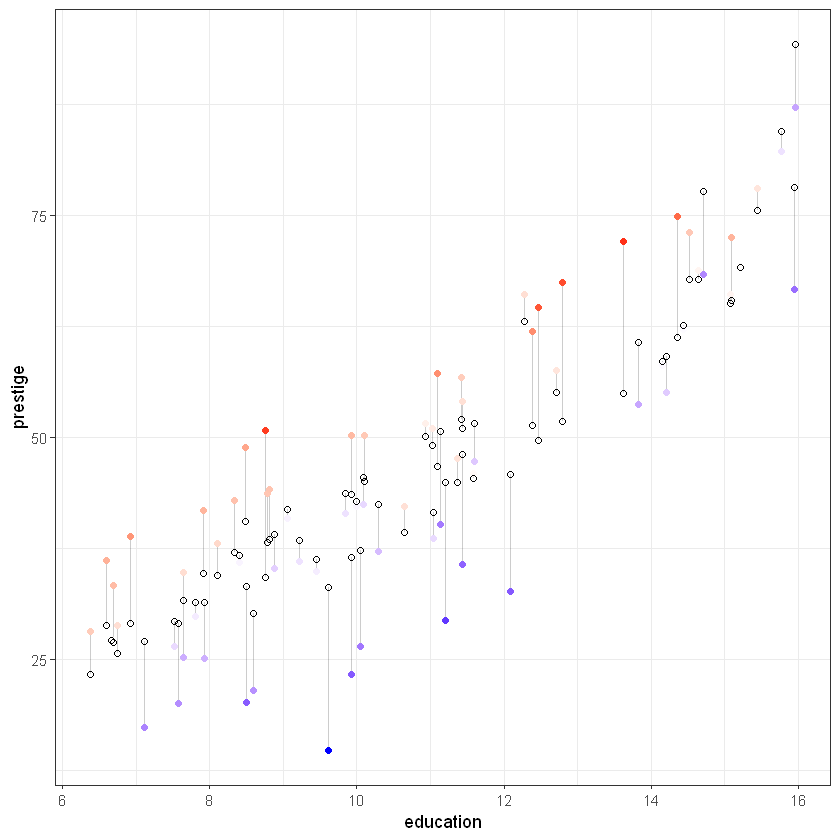

In [27]:
# prestige vs education
ggplot(tmp_data, aes(x = education, y = prestige)) +
  geom_segment(aes(xend = education, yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals)) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1) +
  theme_bw()

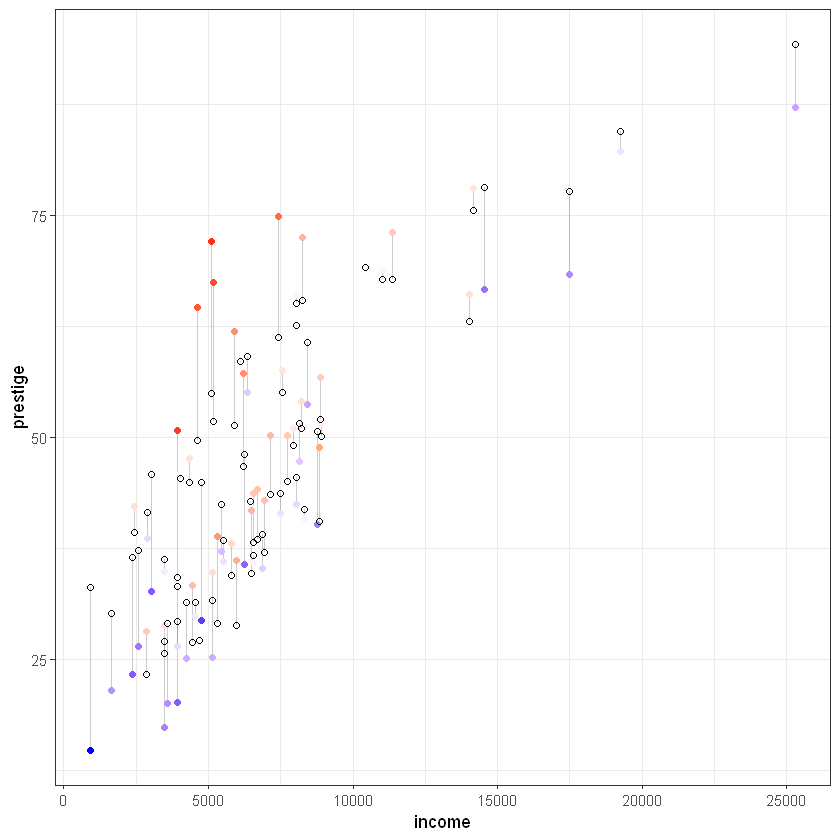

In [28]:
# prestige vs income
ggplot(tmp_data, aes(x = income, y = prestige)) +
  geom_segment(aes(xend = income, yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals)) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1) +
  theme_bw()


# 5. Prediction on test data and accuracy

Здійснимо прогноз за допомогою функції `predict()`.

In [29]:
test_predicted <- predict(lm_mod, test_data)
test_predicted

gov.administrators        general.managers             accountants 
               63.82537                80.69927                57.89563 
               chemists              physicists             draughtsmen 
               63.83951                71.75401                52.75325 
 vocational.counsellors               ministers     university.teachers 
               67.96456                57.81956                75.21065 
primary.school.teachers                 typists             bookkeepers 
               55.81215                43.74329                44.86986 
        shipping.clerks           postal.clerks     telephone.operators 
               37.07250                39.06859                39.92745 
        claim.adjustors           office.clerks    real.estate.salesmen 
               45.17753                43.20989                47.91785 
           firefighters                   cooks       funeral.directors 
               44.41957                29.01981                47.19238 
            babysitters              launderers                 farmers 
               32.01053                27.24206                26.28458 
                 bakers                 canners            auto.workers 
               29.85428                25.93679                35.74439 
   construction.foremen             bus.drivers            longshoremen 
               39.58354                32.04609                33.92975 
            bookbinders 
               32.93787

Обчислимо `MSE`. `MSE` (`Mean Squared Error`) – середньоквадратичне відхилення; середнє значення квадратів відхилень прогнозованих даних від реальних.

In [30]:
mse <- mean((test_data$prestige - test_predicted)^2)
mse

[1] 55.24585

Обчислимо `MAPE`. `MAPE (Mean Absolute Percentage Error)` – середнє абсолютне відхилення прогнозованого показника від реального:

In [31]:
mape <- mean(abs(test_data$prestige - test_predicted)/test_data$prestige)
mape

[1] 0.1344248

Обчислимо швидшим способом метрики моделі за допомогою пакету `modelr` та функцій з нього:

In [32]:
#install.packages("modelr")
library(modelr)
data.frame(
  R2 = rsquare(lm_mod, data = test_data),
  MSE = mse(lm_mod, data = test_data),
  RMSE = rmse(lm_mod, data = test_data),
  MAE = mae(lm_mod, data = test_data),
  MAPE = mape(lm_mod, data = test_data)
)


Attaching package: 'modelr'


The following object is masked from 'package:broom':

    bootstrap




R2,MSE,RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8219865,55.24585,7.432755,6.139407,0.1344248


Mae - Mean Absolute Error. Rmse - Root mean squared error. Детальніше: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.

### Перевірка на мультиколінераність

In [33]:
#install.packages("car") 
library(car)
vif(lm_mod) # VIF-test. If vif >= 4 its multicolinearity

income education 
 1.638937  1.638937

Well done! There are no multicolinearity.

Зафіксуємо значення R^2 для моделі у деякій змінній:

In [34]:
r_sq = rsquare(lm_mod, data = test_data)
r_sq 

[1] 0.8219865

Як видно вище тут мультиколінеарність відсутня.

Введемо в модель додатковий показник, що буде явно залежати від одного з факторів:

In [35]:
lm_mod2 <- lm(formula = prestige ~ income + education + (income:education)^2, data = train_data)
summary(lm_mod2)


Call:
lm(formula = prestige ~ income + education + (income:education)^2, 
    data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.6513  -5.5964   0.5877   3.8355  18.4407 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.794e+01  8.196e+00  -3.409 0.001109 ** 
income            5.404e-03  1.326e-03   4.075 0.000124 ***
education         5.546e+00  6.857e-01   8.089 1.66e-11 ***
income:education -2.779e-04  9.202e-05  -3.020 0.003578 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.595 on 67 degrees of freedom
Multiple R-squared:  0.8148,	Adjusted R-squared:  0.8065 
F-statistic: 98.26 on 3 and 67 DF,  p-value: < 2.2e-16


In [36]:
r_sq2 <- rsquare(lm_mod2, data = test_data)
r_sq
r_sq2

[1] 0.8219865

[1] 0.7840515

VIF-тест для моделі із корельованими змінними:

In [37]:
vif(lm_mod2)

income        education income:education 
       35.439000         4.335637        49.418869

All are > 4. The best way is to exclude the biggest and rebuild model in this case. 

# 6. Extending model

Додамо до моделі категоріальний параметр type. Переглянемо можливі варіанти значень:

In [38]:
unique(train_data$type)

[1] prof bc   wc   <NA>
Levels: bc prof wc

So, its a factor. with 3 values and missing data (NA).

Lets build new model with `type`:

In [39]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
tidy(lm_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.136361132,6.40940196,0.6453584,0.5210019842
income,0.001185453,0.00030302,3.9121280,0.0002240652
education,2.962932038,0.81344875,3.6424323,0.0005422428
typeprof,8.953011569,4.71366761,1.8993727,0.0620240249
typewc,-0.974901943,3.25006054,-0.2999642,0.7651765603


З’явилися нові показники `typeprof` та `typewc`. Вони згенеровані автоматично як `dummy`-змінні функцією `lm()`. Якщо Ви хочете переглянути усі показники, що приймали участь у побудові моделі, то можна викликати $model:

In [40]:
lm_mod$model

,prestige,income,education,type
,<dbl>,<int>,<dbl>,<fct>
civil.engineers,73.1,11377,14.52,prof
textile.weavers,33.3,4443,6.69,bc
tool.die.makers,42.5,8043,10.09,bc
insurance.agents,47.3,8131,11.60,wc
slaughterers.2,34.8,5134,7.64,bc
service.station.attendant,23.3,2370,9.93,bc
computer.operators,47.7,4330,11.36,wc
radio.tv.repairmen,37.2,5449,10.29,bc
electrical.linemen,40.9,8316,9.05,bc


In [43]:
# for better view as html table use DT package
#install.packages("DT")
library(DT)
datatable(lm_mod$model)

HTML widgets cannot be represented in plain text (need html)

---

# 7. Modeling errors 

Переглянемо характеристики моделі:

In [46]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.7801  -4.1603   0.0212   5.2034  20.3020 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.136361   6.409402   0.645 0.521002    
income       0.001185   0.000303   3.912 0.000224 ***
education    2.962932   0.813449   3.642 0.000542 ***
typeprof     8.953012   4.713668   1.899 0.062024 .  
typewc      -0.974902   3.250061  -0.300 0.765177    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.434 on 64 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.8214,	Adjusted R-squared:  0.8102 
F-statistic: 73.59 on 4 and 64 DF,  p-value: < 2.2e-16


Сформуємо розмітку для виведення графіків 4-х графіків одразу (2*2):

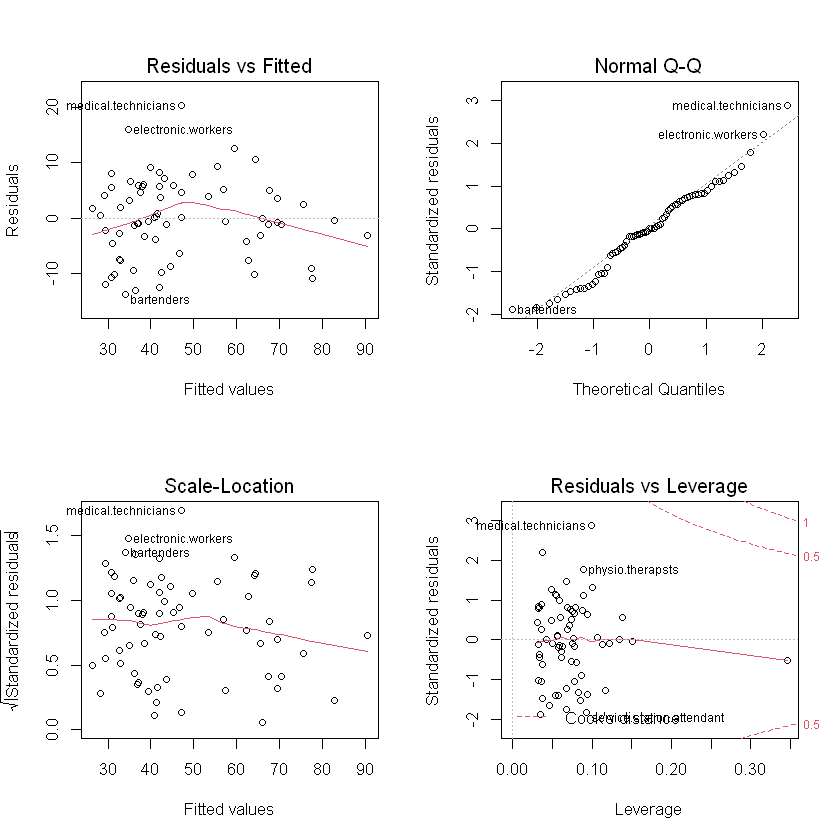

In [48]:
par(mfrow=c(2,2))
plot(lm_mod)

На двох графіках зліва червона лінія показує середнє з відхилень. Якщо варіація похибок зростає разом із збільшенням значень прогнозу - це називається гетероскедастичніть. Прогнозування за таких умов буде давати спотворені результати. Переконаємося у відсутності гетероскедастичності перевіривши `p-value`:

In [52]:
#install.packages("lmtest")
library(lmtest)
bptest(lm_mod)


	studentized Breusch-Pagan test

data:  lm_mod
BP = 9.0675, df = 4, p-value = 0.05943


`p-value > 0.05`, отже ми відхиляємо гіпотезу про те, що гетероскедастичність відсутня (залишки гомоскедастичні - мають однакову дисперсію).

`Normal QQ`-графік дозволяє перевірити чи похибки розподілені за нормальним законом розподілу. Ідеальний варіант коли вони розміщені чітко по діагональній лінії.

На останньому графіку показується як кожне значення впливає на регресію. У статистиці відстань Кука є загальноприйнятою оцінкою впливу спостереження під час застосування методу найменших квадратів у регресійному аналізі.На практиці, при застосуванні методу найменших квадратів, відстань Кука може використовуватися для наступних цілей: визначити впливові спостереження даних, які потрібно перевірити на валідність; визначення областей простору, у яких непогано було б отримати більше результатів спостереження. Джерело: Detection of Influential Observation in Linear Regression / R. Dennis Cook (https://www.jstor.org/stable/1268249?origin=crossref&seq=1)

Повернемо розмітку для 1-го графіка у вікні RStudio:

In [54]:
par(mfrow=c(1,1))

Переглянемо розподіл похибок:

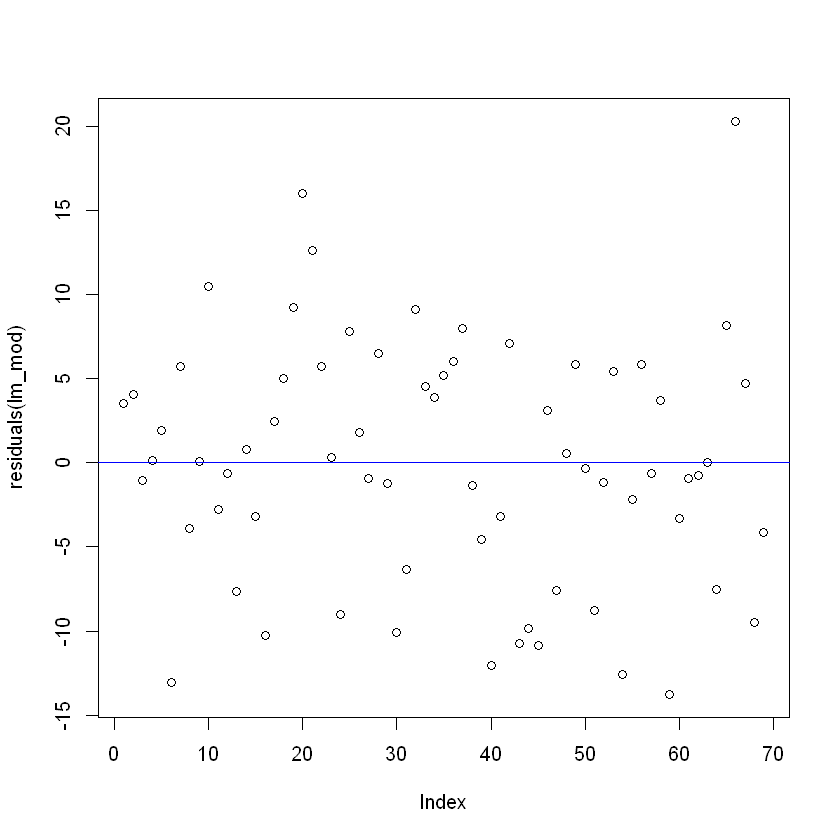

In [56]:
plot(residuals(lm_mod)) 
abline(a=0,b=0,col='blue')

Візуальних закономірностей у похибках немає. Схоже, що вони мають випадковий характер.

---

# 8. Features selection

Ручний відбір параметрів моделі має ряд недоліків, що пов’язані із якістю моделі та затратами часу на її побудову. Вивчимо окремі алгоритми автоматизованого відбору параметрів у модель.

## 8.1. BestSubsets method

Метод `BestSubsets` також відомий як `all possible regressions`. Цей метод відповідно до назв будує всі можливі варіанти моделей на незалежних змінних. Кількість моделей становить $2^p$, де $p$ - кількість неазелжних змінних, так для 10 вхідних параметрів буде побудовано $2^10=1024$ моделей.

In [61]:
#install.packages("leaps")
library(leaps)
best_subsets_mod <- regsubsets(prestige ~ income + education + type + women, data = train_data)

Розгялнемо відібрані параметри моделі BestSubsets. По осі `Y` розміщені значення `BIC`, який обраний як якісний показник регресії, по `X` - параметри моделі:

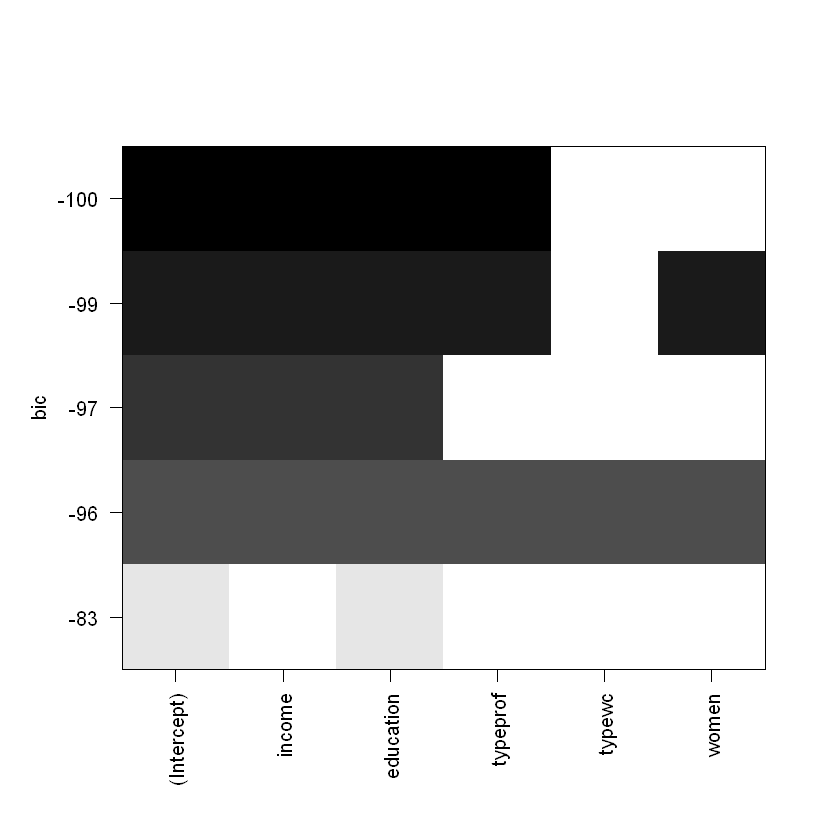

In [62]:
plot(best_subsets_mod)

Найтемніша лінія вказує на найкращу модель.

Перебудуємо модель для усіх можливих варіантів комбінацій параметрів:

In [64]:
best_subsets_mod <- regsubsets(prestige ~ income * education * type * women, data = train_data)

Також можемо обрати кращу модель окремо за критеріями, наприклад скоригований $R^2$:

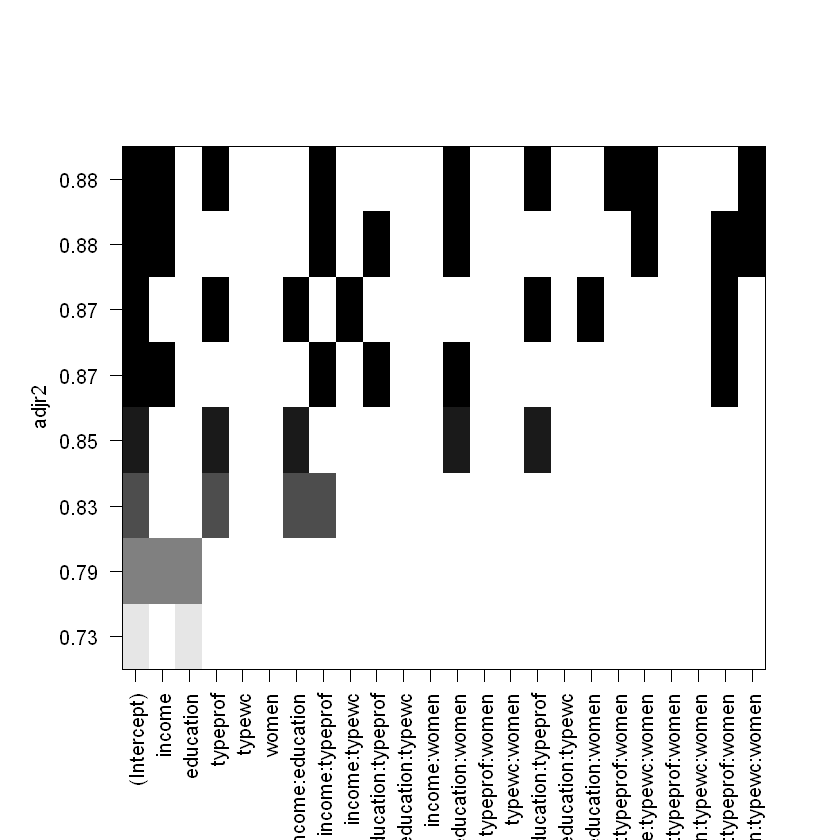

In [66]:
plot(best_subsets_mod, scale = "adjr2")

Моделі з найвищим $R^2$ обираються у такому випадку за цим критерієм, проте не варто забувати про появу мультиколінеарності.

In [76]:
results <- summary(best_subsets_mod)
model_index <- which.max(results$adjr2)
model_index

[1] 8

In [78]:
results$which[model_index,]

(Intercept)                          income 
                           TRUE                            TRUE 
                      education                        typeprof 
                          FALSE                            TRUE 
                         typewc                           women 
                          FALSE                           FALSE 
               income:education                 income:typeprof 
                          FALSE                            TRUE 
                  income:typewc              education:typeprof 
                          FALSE                           FALSE 
               education:typewc                    income:women 
                          FALSE                           FALSE 
                education:women                  typeprof:women 
                           TRUE                           FALSE 
                   typewc:women       income:education:typeprof 
                          FALSE                            TRUE 
        income:education:typewc          income:education:women 
                          FALSE                           FALSE 
          income:typeprof:women             income:typewc:women 
                           TRUE                            TRUE 
       education:typeprof:women          education:typewc:women 
                          FALSE                           FALSE 
income:education:typeprof:women   income:education:typewc:women 
                          FALSE                            TRUE

So, the best regression by Adjusted R-Squared is 

```a0 + a1*income + a2*typeprof + a3*income:typeprof + a4*education:women + a5*income:education:typeprof + a6*income:typeprof:women + a7*income:typewc:women + a8*income:education:typewc:women```

---

## 8.2. Stepwise method

Stepwise - метод, що перебирає можливі варіанти та повертає найкращу модель з найнижчим показником AIC. Перебір моделі може бути з виключенням або з включенням показників у модель - у обох напрямках.

Для початку очистимо дані, що мають пропуски у полі type (також ці дані можна заповнити).

In [81]:
nrow(train_data)
train_data <- train_data[!is.na(train_data$type), ]
nrow(train_data)

[1] 69

[1] 69

Найпростіша модель з одним параметром (першим по списку) матиме вигляд:

In [85]:
start_mod <- lm(prestige ~ 1, data = train_data)

Модель з усіма параметрами:

In [86]:
end_mod <- lm(prestige ~ ., data = train_data)

Запустимо алгоритм функцією `step()`:

In [88]:
stepwise_mod <- step(start_mod, 
                     # set minimum and maximum parameters
                     scope = list(lower = start_mod, upper = end_mod),
                     # direction of model building
                     direction = "both", trace = 1, steps = 1000)
                     # c("both", "backward", "forward") - possible directions

Start:  AIC=392.5
prestige ~ 1

            Df Sum of Sq     RSS    AIC
+ education  1   14514.4  5286.9 303.38
+ type       2   13466.4  6334.9 317.86
+ income     1   10623.3  9178.0 341.44
+ census     1    7498.0 12303.3 361.66
<none>                   19801.3 392.50
+ women      1       2.1 19799.2 394.49

Step:  AIC=303.38
prestige ~ education

            Df Sum of Sq     RSS    AIC
+ income     1    1257.5  4029.4 286.64
+ type       2     904.7  4382.2 294.43
+ census     1     512.7  4774.3 298.35
+ women      1     284.3  5002.6 301.57
<none>                    5286.9 303.38
- education  1   14514.4 19801.3 392.50

Step:  AIC=286.64
prestige ~ education + income

            Df Sum of Sq    RSS    AIC
+ type       2     492.9 3536.5 281.64
<none>                   4029.4 286.64
+ women      1      70.7 3958.8 287.42
+ census     1      47.1 3982.3 287.83
- income     1    1257.5 5286.9 303.38
- education  1    5148.6 9178.0 341.44

Step:  AIC=281.64
prestige ~ education + in

In [91]:
# lets see the summary
summary(stepwise_mod)


Call:
lm(formula = prestige ~ education + income + type + census + 
    women, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0817  -4.9121   0.0985   5.8624  19.7564 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.136e+01  1.058e+01  -1.073 0.287294    
education    3.328e+00  8.821e-01   3.773 0.000363 ***
income       1.307e-03  3.882e-04   3.367 0.001311 ** 
typeprof     1.241e+01  5.318e+00   2.333 0.022930 *  
typewc       7.615e-01  3.732e+00   0.204 0.839003    
census       1.356e-03  7.788e-04   1.741 0.086595 .  
women        6.212e-02  3.928e-02   1.581 0.118911    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.252 on 62 degrees of freedom
Multiple R-squared:  0.8353,	Adjusted R-squared:  0.8194 
F-statistic: 52.42 on 6 and 62 DF,  p-value: < 2.2e-16


> З підсумків моделі видно, що детермінація зросла, тобто модель стала описувати явище ще краще.

---

## References